# Ethereum Price Prediciton 

## Modeling and Preprocessing

### 1. Preprocessing

Since our objective is time-series analysis, our primary focus here will be how to best split our test and train data sets. Some considerations here are that we will likely want our test data split to be analogous with the time nearest where we are forecasting from, either by seasonality or simply the most recent time nearest where we are forecasting from.

In [1]:
#import relevant modules
import sys
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
%matplotlib inline

In [2]:
#establish a base figure size and style for our plots
plt.rcParams["figure.figsize"] = (18,10)
plt.style.use('ggplot')

In [3]:
#!pip install libpython

In [4]:
#!pip install pystan==2.17.1.0

#!pip install fbprophet==0.6

#!pip install --upgrade fbprophet

In [5]:
pd.set_option('display.max_rows', 500)

In [6]:
ETH = pd.read_csv('Data\data_enhanced.csv',index_col='Date', parse_dates=True)
features = pd.read_csv('Data\engineered_features.csv',index_col='Date', parse_dates=True)

In [7]:
ETH.head(10)

,Open,High,Low,Close,Volume,Year,Month,Week,Weekday,Price,LogPrice,LogVol
Date,,,,,,,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,164329.0,2015,8,32,4,2.801870,1.030287,12.009626
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188.0,2015,8,32,5,1.773543,0.572979,13.421264
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170.0,2015,8,32,6,0.704017,-0.350953,13.184718
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283.0,2015,8,33,0,0.711218,-0.340776,12.912341
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100.0,2015,8,33,1,0.887973,-0.118813,14.196068
2015-08-12,1.058750,1.289940,0.883608,1.217440,2150620.0,2015,8,33,2,1.138095,0.129356,14.581267
2015-08-13,1.222240,1.965070,1.171990,1.827670,4068680.0,2015,8,33,3,1.524955,0.421965,15.218829
2015-08-14,1.810920,2.261880,1.754750,1.827870,4637030.0,2015,8,33,4,1.819395,0.598504,15.349585
2015-08-15,1.802890,1.877240,1.570980,1.688900,2554360.0,2015,8,33,5,1.745895,0.557267,14.753312


In [8]:
ETH[['LogPrice']].tail(10)

,LogPrice
Date,
2021-09-18,8.135851
2021-09-19,8.126036
2021-09-20,8.053357
2021-09-21,7.962371
2021-09-22,7.979523
2021-09-23,8.044546
2021-09-24,8.020637
2021-09-25,7.982152
2021-09-26,8.004467


In [9]:
ETH.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2244 entries, 2015-08-07 to 2021-09-27
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      2244 non-null   float64
 1   High      2244 non-null   float64
 2   Low       2244 non-null   float64
 3   Close     2244 non-null   float64
 4   Volume    2244 non-null   float64
 5   Year      2244 non-null   int64  
 6   Month     2244 non-null   int64  
 7   Week      2244 non-null   int64  
 8   Weekday   2244 non-null   int64  
 9   Price     2244 non-null   float64
 10  LogPrice  2244 non-null   float64
 11  LogVol    2244 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 227.9 KB


In [10]:
missing = pd.concat([ETH.isnull().sum(), 100*ETH.isnull().mean()],axis=1)
missing.columns=['count','%']
missing.sort_values(by=['count','%'])

,count,%
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume,0,0.0
Year,0,0.0
Month,0,0.0
Week,0,0.0
Weekday,0,0.0
Price,0,0.0


### 2. Modeling

We will be testing and considering several time-series models, including: ARIMA, exponential smoothing, tbats and Facebook Prophet models. For exponential smoothing, we will likely look to use either the double or triple (also known as Holt_winters Exponential Smoothing) variants since we know our time-series has trend and we will decide between these two based on whether we determine if seasonality is present as well.

In [11]:
#setting our dependent variable
y = ETH['Price']
type(y)

pandas.core.series.Series

In [12]:
y.tail()

Date
2021-09-23    3116.749024
2021-09-24    3043.115601
2021-09-25    2928.225220
2021-09-26    2994.304200
2021-09-27    3074.297974
Name: Price, dtype: float64

In [13]:
rolmean=y.rolling(window=12).mean()

rolstd = y.rolling(window=12).std()

print(rolmean,rolstd)

Date
2015-08-07            NaN
2015-08-08            NaN
2015-08-09            NaN
2015-08-10            NaN
2015-08-11            NaN
                 ...     
2021-09-23    3291.042898
2021-09-24    3266.284770
2021-09-25    3231.429220
2021-09-26    3201.142649
2021-09-27    3163.729981
Name: Price, Length: 2244, dtype: float64 Date
2015-08-07           NaN
2015-08-08           NaN
2015-08-09           NaN
2015-08-10           NaN
2015-08-11           NaN
                 ...    
2021-09-23    229.817279
2021-09-24    239.823885
2021-09-25    256.894500
2021-09-26    262.021582
2021-09-27    243.226108
Name: Price, Length: 2244, dtype: float64


<AxesSubplot:xlabel='Date'>

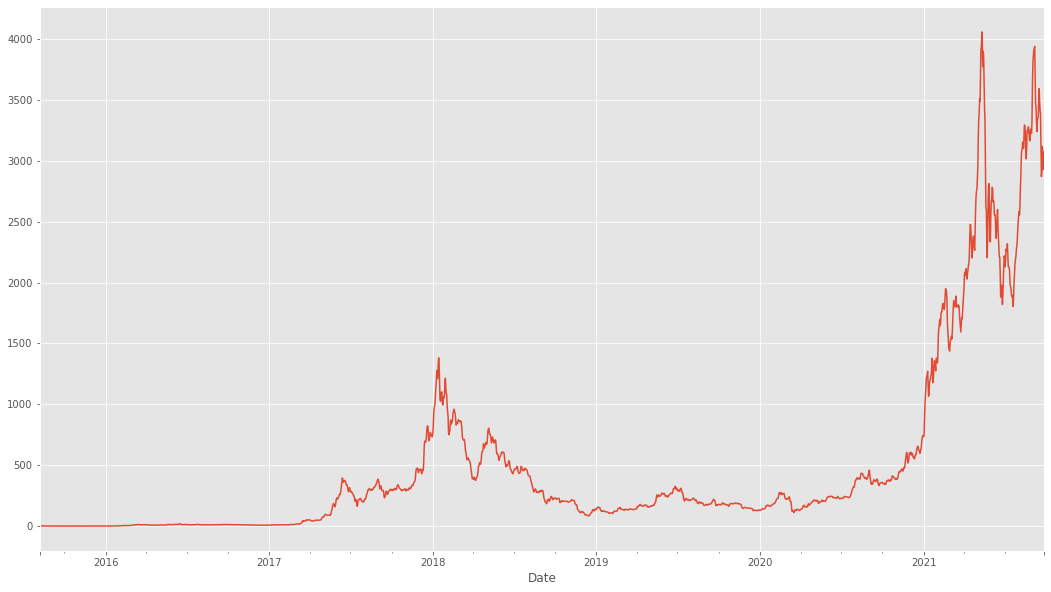

In [14]:
y.plot()

In [15]:
#Aggregating our times
#df_agg=ETH.groupby('Date')[['Price']].sum()

In [16]:
#checking that our index is still datetime
#type(df_agg.index)

In [17]:
#resampling for weekly timeseries
y=ETH[['Price']].resample('W').mean()
#y = ETH[['Price']]
y.head()

,Price
Date,
2015-08-09,1.759810
2015-08-16,1.350389
2015-08-23,1.328926
2015-08-30,1.198094
2015-09-06,1.313124


Text(0, 0.5, 'Seasonality')

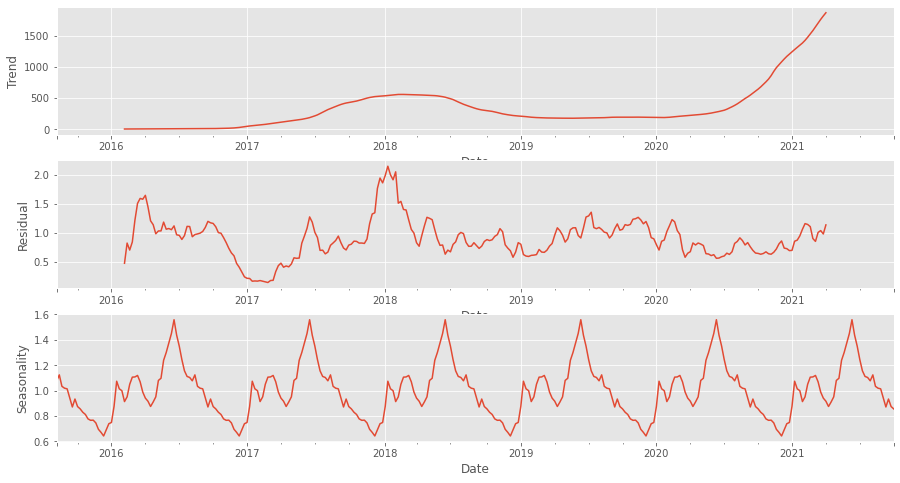

In [18]:
decomposition = sm.tsa.seasonal_decompose(y,model = 'multiplicative')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)

ax1.set_ylabel("Trend")
ax2.set_ylabel("Residual")
ax3.set_ylabel("Seasonality")

In [19]:
#performing kpss test for stationarity as prelimiary test
from statsmodels.tsa.stattools import kpss

kpss(y)

C:\Users\nicho\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\nicho\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.8392481556733852,
 0.01,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [20]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dicky-Fuller Test:')
dftest = adfuller(y,autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dicky-Fuller Test:
Test Statistic                   1.439468
p-value                          0.997286
#lags used                      13.000000
Number of Observations Used    308.000000
Critical Value (1%)             -3.451761
Critical Value (5%)             -2.870970
Critical Value (10%)            -2.571794
dtype: float64


In [21]:
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(movingAverage,color='red',label='Rolling Mean')
    std = plt.plot(movingSTD,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

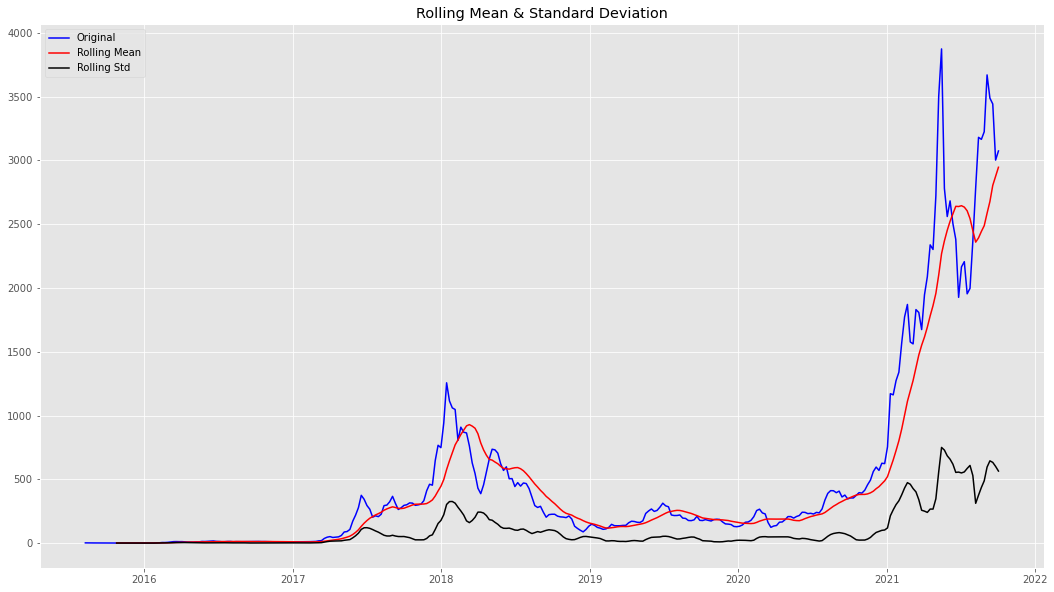

Results of Dickey-Fuller Test:
Test Statistic                   1.439468
p-value                          0.997286
#lags used                      13.000000
Number of Observations Used    308.000000
Critical Value (1%)             -3.451761
Critical Value (5%)             -2.870970
Critical Value (10%)            -2.571794
dtype: float64


In [22]:
test_stationarity(y)

In [23]:
y_diff =y.diff().dropna()

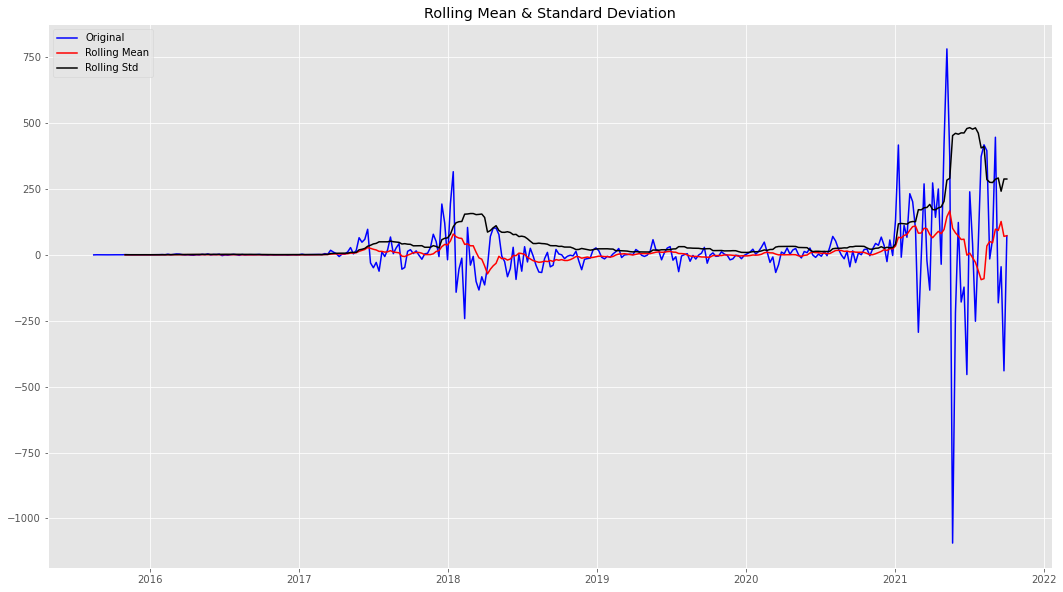

Results of Dickey-Fuller Test:
Test Statistic                  -2.246887
p-value                          0.189670
#lags used                      17.000000
Number of Observations Used    303.000000
Critical Value (1%)             -3.452118
Critical Value (5%)             -2.871127
Critical Value (10%)            -2.571878
dtype: float64


In [24]:
test_stationarity(y_diff)

In [25]:
y_log=np.log(y)

In [26]:
kpss(y_diff.dropna())

C:\Users\nicho\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


(0.4273599163347888,
 0.06536210502810827,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

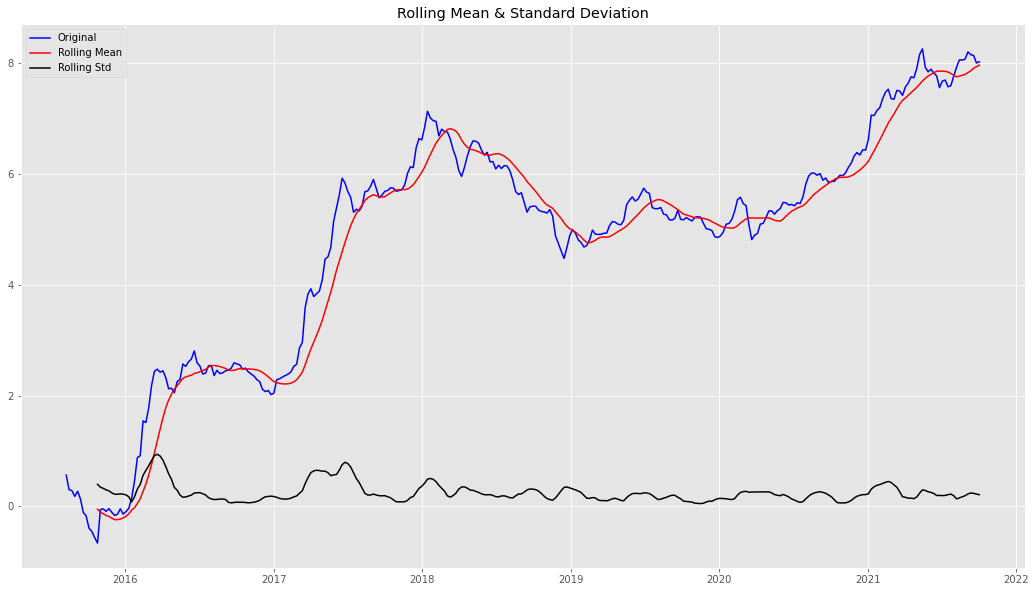

Results of Dickey-Fuller Test:
Test Statistic                  -1.590277
p-value                          0.488476
#lags used                       2.000000
Number of Observations Used    319.000000
Critical Value (1%)             -3.451017
Critical Value (5%)             -2.870643
Critical Value (10%)            -2.571620
dtype: float64


In [27]:
test_stationarity(y_log)

<AxesSubplot:xlabel='Date'>

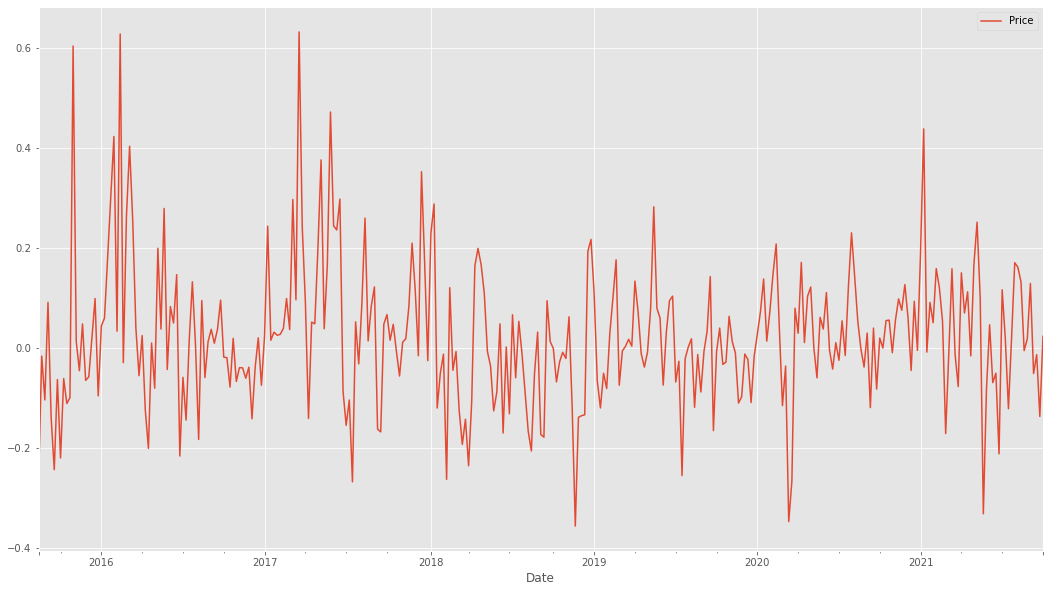

In [28]:
y_log_diff = y_log.diff().dropna()
y_log_diff.plot()

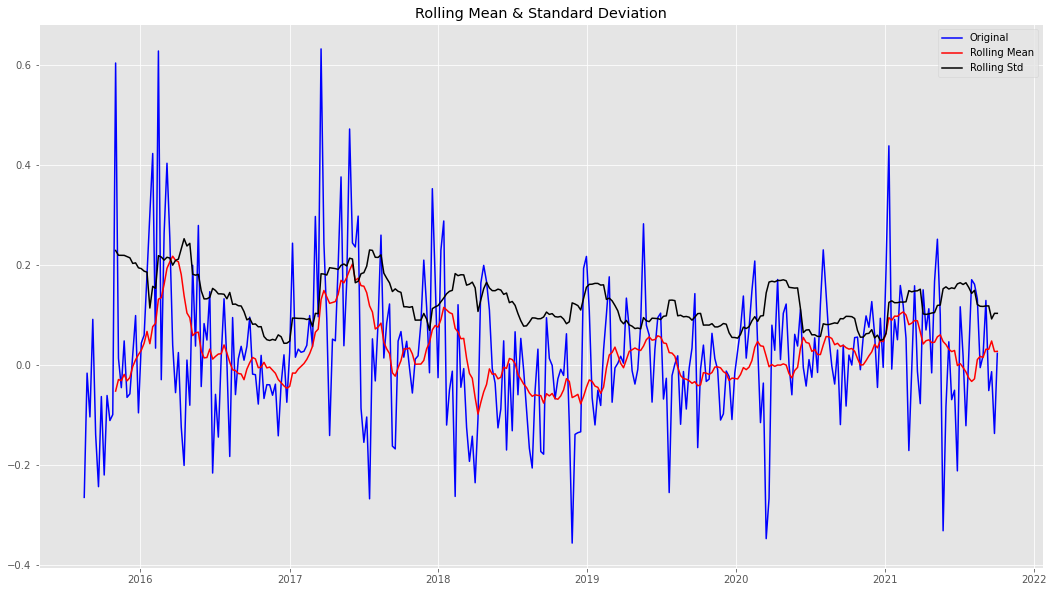

Results of Dickey-Fuller Test:
Test Statistic                -9.207717e+00
p-value                        1.924696e-15
#lags used                     1.000000e+00
Number of Observations Used    3.190000e+02
Critical Value (1%)           -3.451017e+00
Critical Value (5%)           -2.870643e+00
Critical Value (10%)          -2.571620e+00
dtype: float64


In [29]:
test_stationarity(y_log_diff)

y_log_diff rejects the null hypothesis via the ad fuller test.

In [30]:
#creating moving average and std for y_log
movingAverage = y_log.rolling(window=4).mean()
movingSTD = y_log.rolling(window=4).std()

In [31]:
y_log_minusmovingAverage = y_log - movingAverage
y_log_minusmovingAverage.head(10)

y_log_minusmovingAverage.dropna(inplace=True)
y_log_minusmovingAverage.head()

,Price
Date,
2015-08-30,-0.151943
2015-09-06,0.012933
2015-09-13,-0.084109
2015-09-20,-0.228954
2015-09-27,-0.203536


In [32]:
y_log_minusmovingAverage.tail()

,Price
Date,
2021-09-05,0.105156
2021-09-12,0.031187
2021-09-19,-0.002924
2021-09-26,-0.121897
2021-10-03,-0.053983


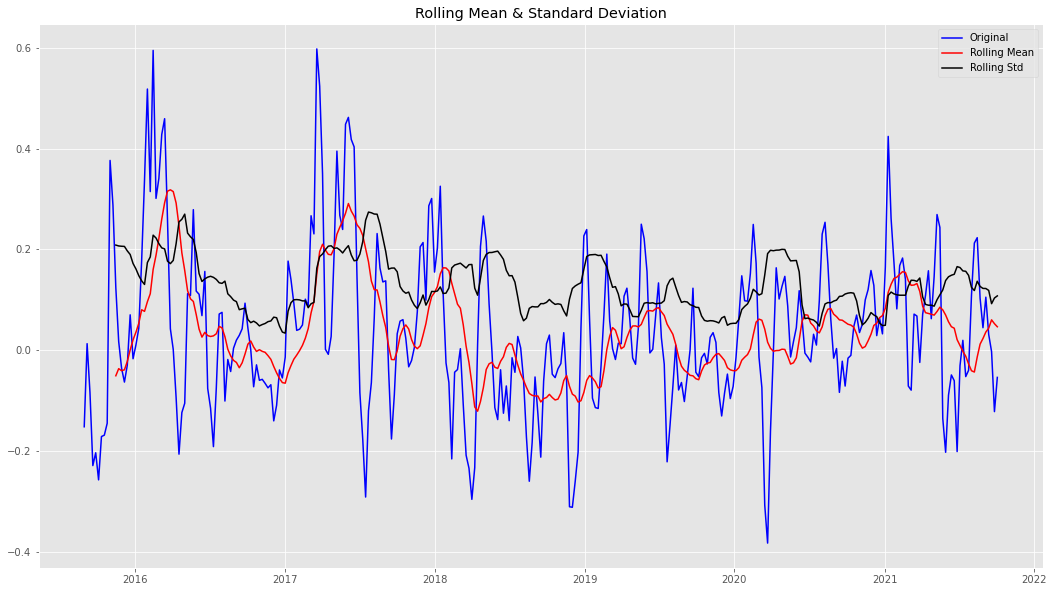

Results of Dickey-Fuller Test:
Test Statistic                -6.810738e+00
p-value                        2.119530e-09
#lags used                     3.000000e+00
Number of Observations Used    3.150000e+02
Critical Value (1%)           -3.451281e+00
Critical Value (5%)           -2.870760e+00
Critical Value (10%)          -2.571682e+00
dtype: float64


In [33]:
test_stationarity(y_log_minusmovingAverage)

<AxesSubplot:xlabel='Date'>

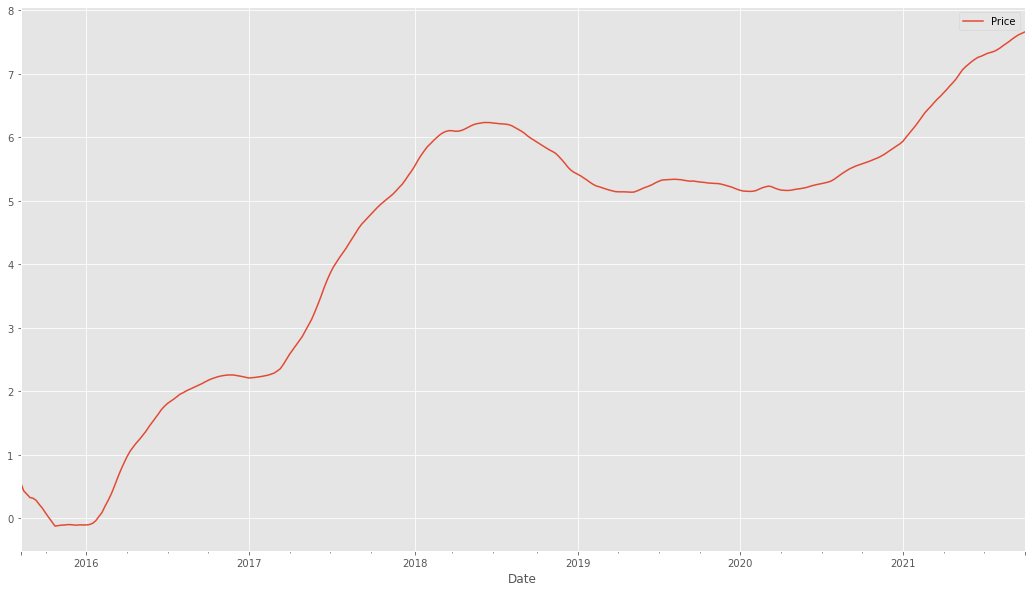

In [34]:
expentialDecayWeightedAverage = y_log.ewm(halflife=12,min_periods=0,adjust=True).mean()
expentialDecayWeightedAverage.plot()

Text(0, 0.5, 'Seasonality')

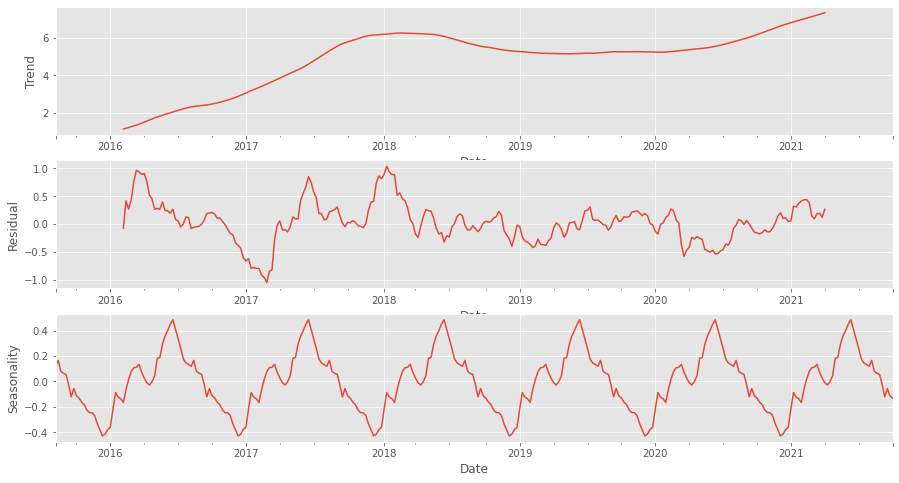

In [35]:
#plotting decomposition of our log scale timeseries
decomposition = sm.tsa.seasonal_decompose(y_log)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)

ax1.set_ylabel("Trend")
ax2.set_ylabel("Residual")
ax3.set_ylabel("Seasonality")

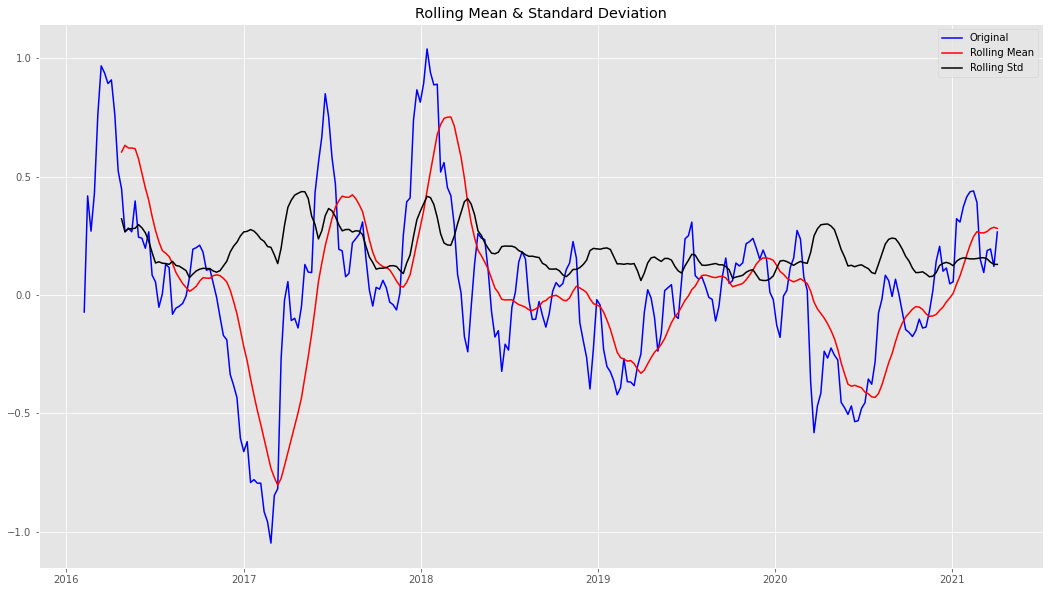

Results of Dickey-Fuller Test:
Test Statistic                  -4.017634
p-value                          0.001321
#lags used                       2.000000
Number of Observations Used    267.000000
Critical Value (1%)             -3.455081
Critical Value (5%)             -2.872427
Critical Value (10%)            -2.572571
dtype: float64


In [36]:
#testing stationarity of our noise (residuals)
decomposedLogData = decomposition.resid
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

<AxesSubplot:xlabel='Date'>

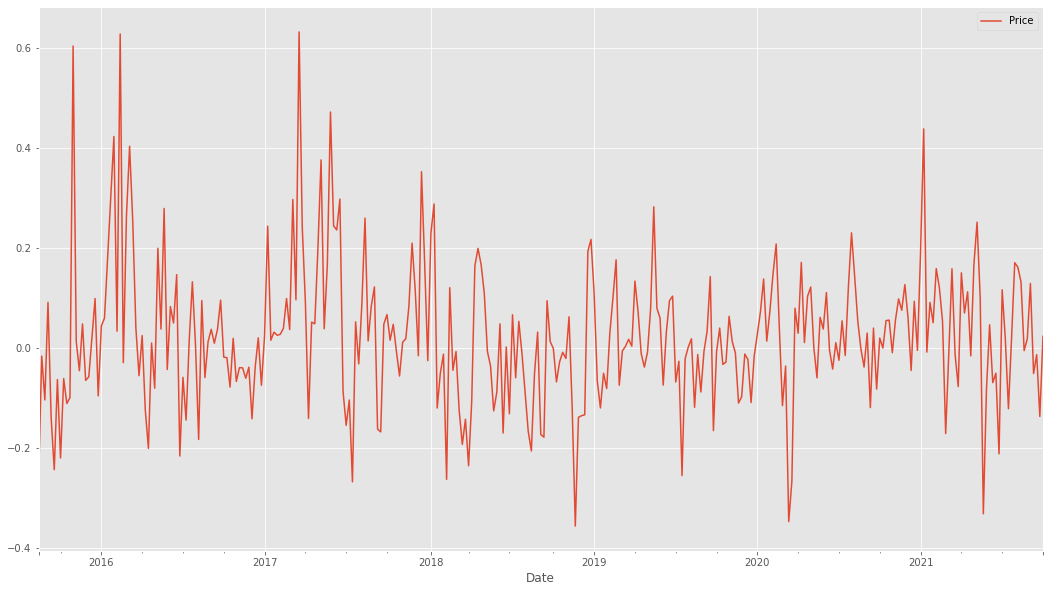

In [37]:
y_log_diff.plot()

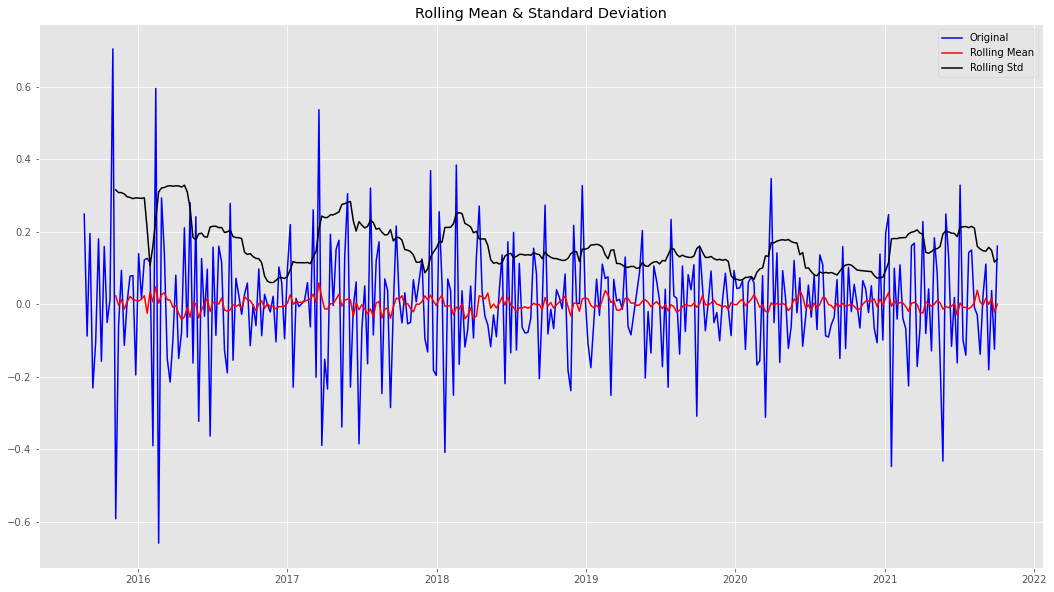

Results of Dickey-Fuller Test:
Test Statistic                -1.001192e+01
p-value                        1.769377e-17
#lags used                     1.000000e+01
Number of Observations Used    3.090000e+02
Critical Value (1%)           -3.451691e+00
Critical Value (5%)           -2.870939e+00
Critical Value (10%)          -2.571778e+00
dtype: float64


In [38]:
y_log_diff_shifted = y_log_diff - y_log_diff.shift()
y_log_diff_shifted.dropna(inplace=True)
test_stationarity(y_log_diff_shifted)

## ARIMA Model

In [39]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [40]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [41]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [42]:
# Choose range of values to evaluate for our ARIMA model order
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

import warnings
warnings.filterwarnings("ignore")
evaluate_models(ETH['Price'],p_values,d_values,q_values)
ARIMA(0, 0, 0) MSE=2703599.190
ARIMA(0, 0, 1) MSE=678726.517
ARIMA(0, 1, 0) MSE=5838.153
ARIMA(0, 1, 1) MSE=3621.229
ARIMA(0, 1, 2) MSE=3638.542
ARIMA(0, 2, 0) MSE=6093.752
ARIMA(0, 2, 1) MSE=6320.794
ARIMA(0, 2, 2) MSE=3658.455
ARIMA(1, 0, 0) MSE=5847.802
ARIMA(1, 1, 0) MSE=4546.990
ARIMA(1, 1, 1) MSE=3644.108
ARIMA(1, 1, 2) MSE=3680.236
ARIMA(1, 2, 0) MSE=6109.276
ARIMA(1, 2, 1) MSE=4578.223
ARIMA(1, 2, 2) MSE=3744.000
ARIMA(2, 0, 0) MSE=4567.065
ARIMA(2, 1, 0) MSE=4351.848
ARIMA(2, 1, 1) MSE=3654.062
ARIMA(2, 1, 2) MSE=3722.556
ARIMA(2, 2, 0) MSE=4669.266
ARIMA(2, 2, 1) MSE=4758.543
ARIMA(2, 2, 2) MSE=3790.494
Best ARIMA(0, 1, 1) MSE=3621.229

C:\Users\nicho\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation Function')

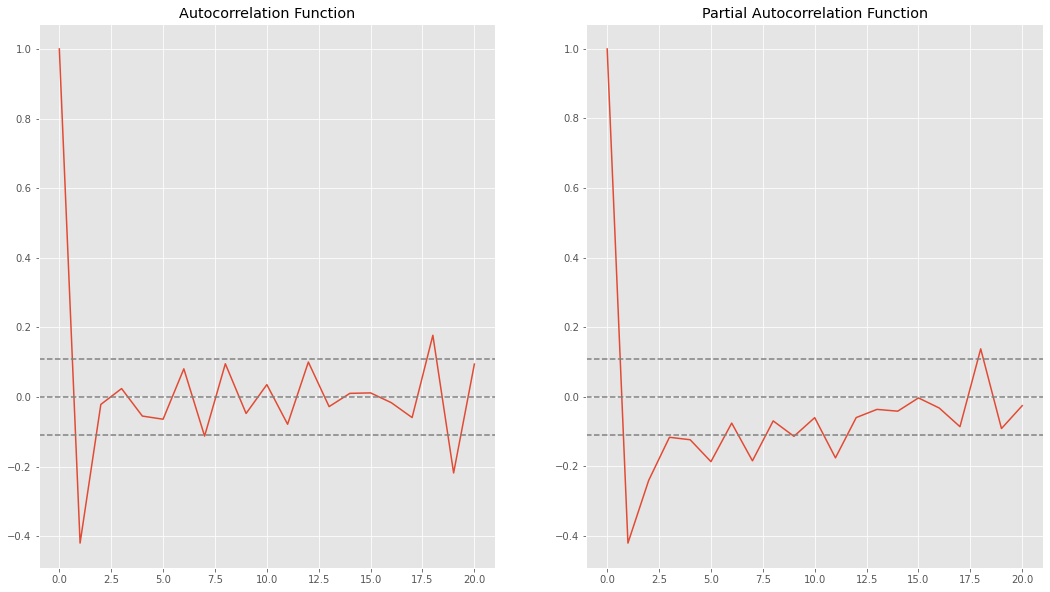

In [43]:
#ACF and PCF Plots:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(y_log_diff_shifted, nlags=20)
lag_pacf = pacf(y_log_diff_shifted, nlags=20, method='ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PCF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

We will be using the ACF plot to find our P value and PACF for find our Q value. Looking at where the ACF and PACF functions touch zero for the first times we can see the P value is roughly equal to 3.75 or 4, and the Q value is around 3.

Plotting AR model


C:\Users\nicho\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


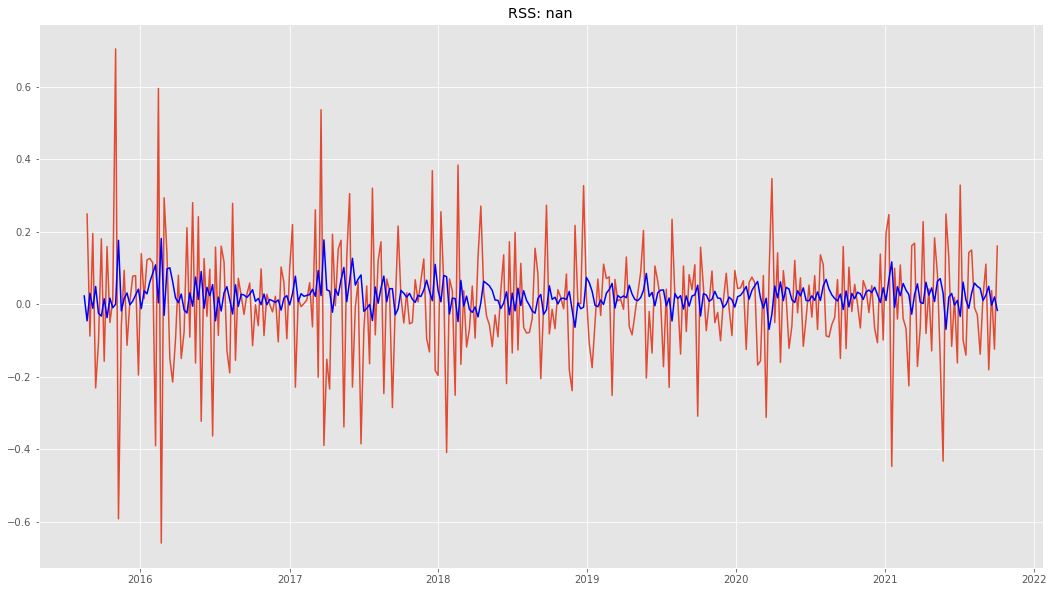

In [81]:
from statsmodels.tsa.arima_model import ARIMA

#ARIMA Model
model = ARIMA(y_log, order=(0,1,1))
model_fit = model.fit(disp=-1)
plt.plot(y_log_diff_shifted)
plt.plot(model_fit.fittedvalues,color='blue')
plt.title('RSS: %.4f'% sum((model_fit.fittedvalues-y_log_diff_shifted['Price'])**2))
print('Plotting AR model')

In [82]:
#forecasting
ARIMA_forecast = model_fit.forecast(24)

In [83]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  321
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 183.294
Method:                       css-mle   S.D. of innovations              0.137
Date:                Thu, 11 Nov 2021   AIC                           -360.589
Time:                        10:13:19   BIC                           -349.274
Sample:                    08-16-2015   HQIC                          -356.071
                         - 10-03-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0231      0.010      2.413      0.016       0.004       0.042
ma.L1.D.Price     0.2535      0.048      5.264      0.000       0.159       0.348
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.9450           +0.0000j            3.9450            0.5000
-----------------------------------------------------------------------------
"""

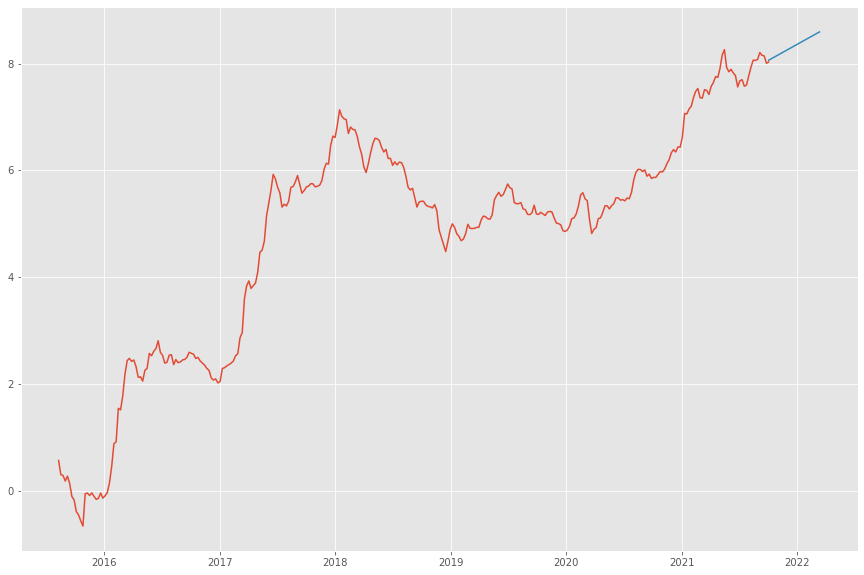

In [84]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='W-SUN').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
future_weeks = pd.DataFrame(date_range, columns = ['Week'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_weeks['W'] = pd.to_datetime(future_weeks['Week'])
future_weeks.set_index('Week', inplace = True)
future_weeks.index = pd.to_datetime(future_weeks.index)
future_weeks=future_weeks.drop('W',axis=1)
future_weeks['Prediction'] = ARIMA_forecast[0]
future_weeks = future_weeks.asfreq('W-SUN')


# Plot future predictions
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(future_weeks['Prediction'])
plt.show()

In [85]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Date
2015-08-16    0.023062
2015-08-23   -0.045505
2015-08-30    0.030507
2015-09-06   -0.010934
2015-09-13    0.049072
2015-09-20   -0.024540
2015-09-27   -0.032404
2015-10-04    0.015330
2015-10-11   -0.036591
2015-10-18    0.016920
2015-10-25   -0.009344
2015-11-01    0.000308
2015-11-08    0.176334
2015-11-15   -0.018161
2015-11-22    0.016221
2015-11-29    0.031242
2015-12-06   -0.001220
2015-12-13    0.008797
2015-12-20    0.025935
2015-12-27    0.041650
2016-01-03   -0.011716
2016-01-10    0.037249
2016-01-17    0.028858
2016-01-24    0.062028
2016-01-31    0.085722
2016-02-07    0.108763
2016-02-14    0.004108
2016-02-21    0.181477
2016-02-28   -0.030333
2016-03-06    0.097780
2016-03-13    0.100746
2016-03-20    0.062094
2016-03-27    0.017547
2016-04-03    0.004649
2016-04-10    0.028278
2016-04-17   -0.015524
2016-04-24   -0.023912
2016-05-01    0.031706
2016-05-08   -0.005325
2016-05-15    0.075100
2016-05-22    0.013692
2016-05-29    0.090485
2016-06-05   -0.010742
2016-0

In [74]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Date
2015-08-16    0.023062
2015-08-23   -0.022443
2015-08-30    0.008064
2015-09-06   -0.002870
2015-09-13    0.046203
2015-09-20    0.021663
2015-09-27   -0.010742
2015-10-04    0.004588
2015-10-11   -0.032002
2015-10-18   -0.015083
2015-10-25   -0.024426
2015-11-01   -0.024118
2015-11-08    0.152216
2015-11-15    0.134055
2015-11-22    0.150276
2015-11-29    0.181518
2015-12-06    0.180298
2015-12-13    0.189095
2015-12-20    0.215030
2015-12-27    0.256680
2016-01-03    0.244964
2016-01-10    0.282213
2016-01-17    0.311071
2016-01-24    0.373099
2016-01-31    0.458821
2016-02-07    0.567584
2016-02-14    0.571692
2016-02-21    0.753169
2016-02-28    0.722835
2016-03-06    0.820616
2016-03-13    0.921361
2016-03-20    0.983455
2016-03-27    1.001002
2016-04-03    1.005651
2016-04-10    1.033929
2016-04-17    1.018405
2016-04-24    0.994493
2016-05-01    1.026198
2016-05-08    1.020873
2016-05-15    1.095974
2016-05-22    1.109665
2016-05-29    1.200150
2016-06-05    1.189408
2016-0

In [75]:
predictions_ARIMA_log = pd.Series(y_log['Price'].iloc[0], index=y_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2015-08-09    0.565206
2015-08-16    0.588268
2015-08-23    0.542763
2015-08-30    0.573270
2015-09-06    0.562336
Freq: W-SUN, dtype: float64

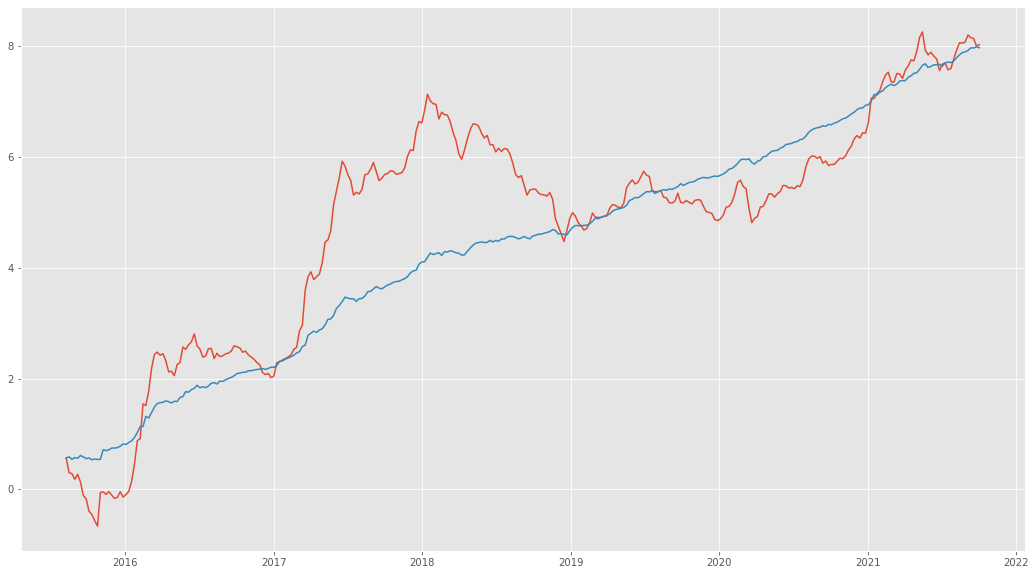

In [92]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(y_log['Price'])
plt.plot(predictions_ARIMA_log)

In [86]:
y_log.shape

(322, 1)

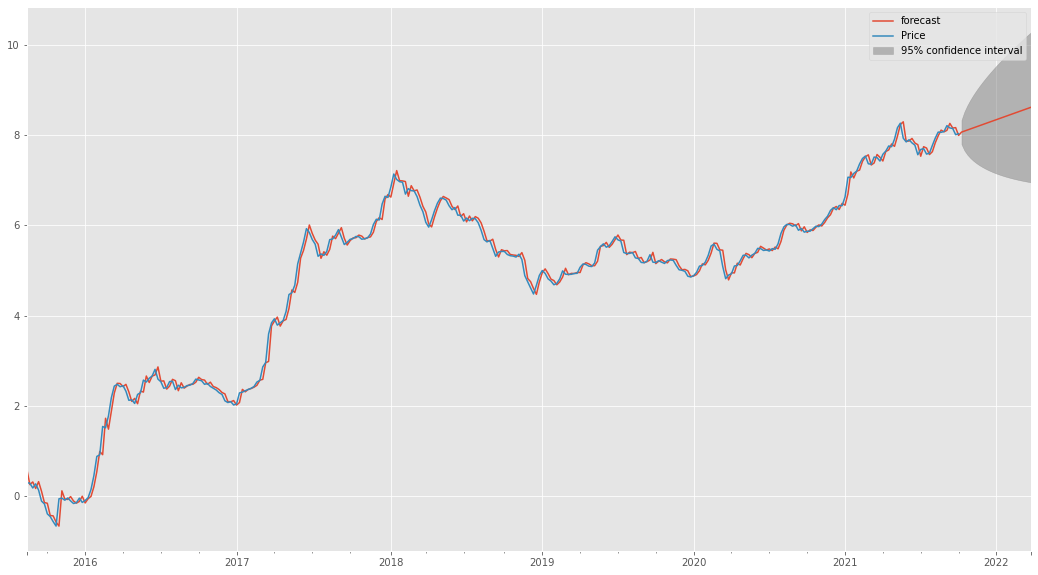

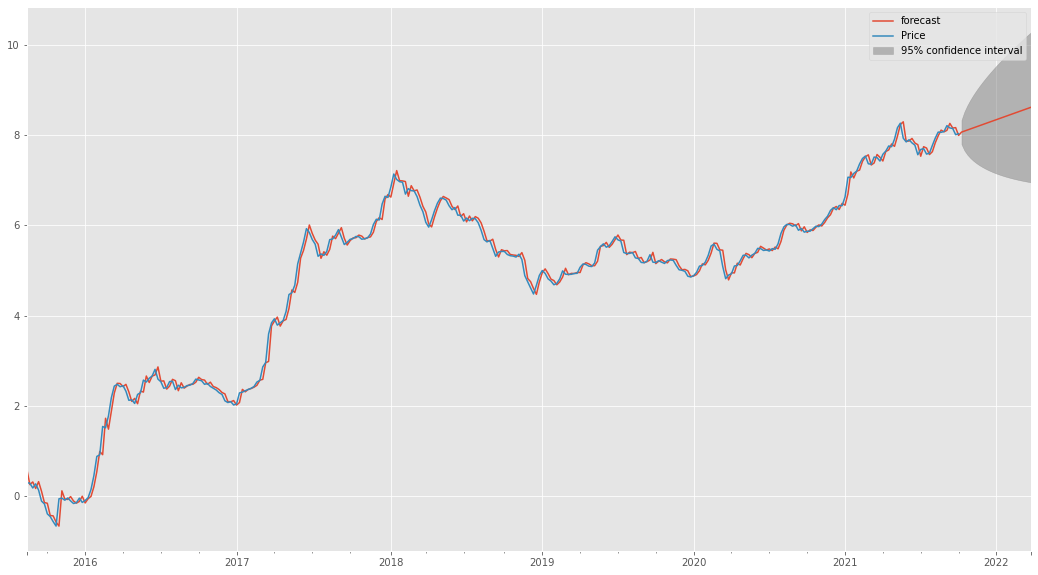

In [89]:
model_fit.plot_predict(1,346)

In [93]:
!pip install tbats

In [94]:
from tbats import TBATS

In [95]:
!pip install atspy

  Created wheel for atspy: filename=atspy-0.2.3-py3-none-any.whl size=16007 sha256=7d445e858e5ed30346dfa2d97e33623bf78cd2163659370f80406b84c694ccff
  Stored in directory: c:\users\nicho\appdata\local\pip\cache\wheels\c3\67\2d\99bc5c1ab19f550f55c064f515c6e928ffb9ea6a59763adb87
Successfully built atspy


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\nicho\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\nicho\\AppData\\Local\\Temp\\pip-install-j7bz3jy1\\psycopg2_9e4c4f930455465b9ffe235def9e3f92\\setup.py'"'"'; __file__='"'"'C:\\Users\\nicho\\AppData\\Local\\Temp\\pip-install-j7bz3jy1\\psycopg2_9e4c4f930455465b9ffe235def9e3f92\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\nicho\AppData\Local\Temp\pip-pip-egg-info-qhr819sm'
         cwd: C:\Users\nicho\AppData\Local\Temp\pip-install-j7bz3jy1\psycopg2_9e4c4f930455465b9ffe235def9e3f92\
    Complete output (23 lines):
    running egg_info
    creating C:\Users\nicho\AppData\Local\Temp\pip-pip-egg-info-qhr819sm\psycopg2.egg-info
    writing C:\Users\nicho\AppData\Local\Temp\pip-pip-egg-info-qhr819sm\psycopg2.egg-inf